In [4]:
#automatically reload stuff
%load_ext autoreload
%autoreload 2
import Utils
import matplotlib.pyplot as plt
from SpatialPreprocessing import *
import json
import Formatting
from Constants import Const
import copy
import Metrics
import Models
import re
import Cluster
pd.set_option('display.max_columns', None)

from Levenshtein import distance as levenshtein_distance
import collections

In [6]:
from warnings import simplefilter 
simplefilter(action='ignore')

In [8]:
rds = RadDataset()
rds.get_value_array(['mean_dose','V10'],keep_2d=True).shape

spellchecking...
renaming things
filtering pateints
adding nan values for missing organs
adding histograms


In [10]:
rds.dvh_df[rds.dvh_df.id == 2]

,ROI,id,Structure,volume,mean_dose,min_dose,max_dose,V5,V10,V15,V20,V25,V30,V35,V40,V45,V50,V55,V60,V65,V70,V75,V80,D2,D5,D10,D15,D20,D25,D30,D35,D40,D45,D50,D55,D60,D65,D70,D75,D80,D85,D90,D95,D97,D98,D99
0,Esophagus,2.0,Esophagus_U,14279.479980,35.720554,297.0,5827.0,96.37500,91.56250,88.250000,85.687500,82.937500,78.937500,59.875000,39.000000,23.890625,14.367188,1.211914,0.000000,0.000000,0.000000,0.0,0.0,54.531250,53.218750,51.625000,49.781250,47.093750,44.437500,42.531250,41.031250,39.781250,38.437500,37.156250,36.031250,34.968750,34.000000,33.031250,31.812500,29.187500,21.343750,13.140625,6.160156,4.710938,4.011719,3.500000
1,Spinal_Cord,2.0,SpinalCord_Cerv,12866.363525,23.816881,1768.0,3008.0,100.00000,100.00000,100.000000,93.875000,31.187500,0.032013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,28.187500,27.437500,26.890625,26.515625,25.875000,25.453125,25.078125,24.703125,24.375000,24.125000,23.890625,23.625000,23.328125,23.015625,22.687500,22.359375,21.984375,21.531250,20.906250,19.453125,18.781250,18.453125,18.062500
2,Lt_Brachial_Plexus,2.0,Brachial_Plex_L,7139.739990,36.247807,341.0,6272.0,95.68750,80.00000,75.500000,72.562500,70.312500,68.062500,65.437500,58.500000,44.593750,29.078125,13.734375,1.673828,0.000000,0.000000,0.0,0.0,59.843750,58.281250,56.187500,54.687500,53.093750,51.375000,49.718750,48.031250,46.468750,44.875000,43.375000,41.687500,39.218750,35.468750,25.656250,16.375000,9.968750,7.468750,6.308594,5.230469,4.621094,4.199219,3.960938
3,Rt_Brachial_Plexus,2.0,Brachial_Plex_R,5500.030518,42.946247,1308.0,6034.0,100.00000,100.00000,99.000000,98.375000,96.250000,89.375000,79.625000,67.187500,47.937500,23.812500,6.218750,0.524414,0.000000,0.000000,0.0,0.0,57.406250,55.500000,53.625000,52.218750,50.875000,49.750000,48.687500,47.750000,46.625000,45.687500,44.562500,43.375000,42.000000,40.750000,39.125000,37.125000,34.812500,32.312500,29.734375,26.031250,22.312500,20.515625,14.953125
4,Cricopharyngeal_Muscle,2.0,Cricopharyngeus,2698.516846,49.904351,4070.0,5747.0,100.00000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,90.250000,52.531250,4.582031,0.000000,0.000000,0.000000,0.0,0.0,55.937500,54.906250,53.750000,52.968750,52.437500,52.031250,51.656250,51.312500,51.000000,50.562500,50.250000,49.812500,49.593750,49.218750,48.812500,48.187500,47.781250,46.687500,45.000000,43.031250,42.593750,41.906250,41.187500
5,Cricoid_cartilage,2.0,Cricoid,8964.843750,48.690312,2579.0,6842.0,100.00000,100.00000,100.000000,100.000000,100.000000,99.062500,93.187500,83.062500,70.375000,50.468750,20.953125,6.203125,1.148438,0.000000,0.0,0.0,63.718750,60.875000,57.812500,56.187500,55.187500,54.187500,53.375000,52.625000,51.875000,51.062500,50.156250,48.968750,47.843750,46.562500,45.125000,43.375000,41.281250,38.968750,36.843750,33.937500,32.750000,31.812500,30.046875
6,IPC,2.0,Musc_Constrict_I,2900.390625,41.851960,2834.0,5989.0,100.00000,100.00000,100.000000,100.000000,100.000000,99.125000,89.375000,62.500000,22.578125,10.226562,3.550781,0.000000,0.000000,0.000000,0.0,0.0,56.125000,53.312500,50.187500,47.500000,45.343750,44.437500,43.437500,43.093750,42.562500,42.062500,41.281250,40.875000,40.468750,39.656250,38.968750,38.156250,37.250000,36.062500,34.812500,32.781250,31.656250,31.140625,30.156250
7,MPC,2.0,Musc_Constrict_M,1384.277344,66.409821,5067.0,7380.0,100.00000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,97.625000,90.750000,53.281250,38.406250,0.0,0.0,73.187500,73.000000,72.625000,72.312500,72.000000,71.437500,70.750000,70.375000,69.750000,67.000000,65.812500,64.687500,64.250000,63.718750,63.343750,62.687500,62.218750,61.593750,60.375000,57.187500,56.187500,53.843750,52.312500
8,Brainstem,2.0,Brainstem,22704.620361,6.866349,92.0,2931.0,30.71875,23.96875,19.250000,14.531250,4.628906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,26.531250,24.875000,22.562500,19.703

In [149]:
from sklearn.feature_selection import mutual_info_regression
dvh_array = rds.get_value_array(rds.get_dvh_columns('V')[0],per_organ=True)
mdose = rds.get_value_array(['mean_dose'],per_organ=True)
mi = mutual_info_regression(dvh_array,mdose)
pd.DataFrame(mi.reshape(1,-1),columns=rds.get_dvh_columns('V')[0])

/home/evl/andrew/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,V5,V10,V15,V20,V25,V30,V35,V40,V45,V50,V55,V60,V65,V70,V75,V80
0,0.509773,0.759494,1.053033,1.194065,1.293102,1.350013,1.348274,1.313934,1.273572,1.227948,1.132527,0.816441,0.638393,0.439551,0.013285,0.002973


In [180]:
feature_candidates = [
    ['mean_dose'],
    ['V60'],
    ['V35'],
    ['V35','V40','V45'],
    ['mean_dose','V60'],
    ['mean_dose','V10','V65'],
    ['V10','V60'],
    ['V15','V60'],
    ['V10','V20','V60'],
    ['V15','V25','V35','V45','V55','V65'],
    ['V15','V20','V25','V30','V35','V40','V45','V50','V55','V60'],
    ['V5','V10','V15','V20','V25','V30','V35','V40','V45','V50','V55','V60','V65','V70','V75','V80'],
]
n_clusters = [3,4,5]
sim_measure_dict = {
        'euclidean': Metrics.Euclidean2D(),
        'cosine': Metrics.Cosine2d(),
        'chi2': Metrics.ChiSquared2d(),
        'jaccard': Metrics.Jaccard2d(),
       'em': Metrics.Wasserstein2d(),
    }
links = ['ward','weighted']
results = []
for features in feature_candidates:
    print(features)
    array = rds.get_value_array(features,keep_2d= len(features) < 3)
    for n in n_clusters:
        for link in links:
            clusterer = Cluster.SimilarityClusterer(n,link=link)
            for sname, sim in sim_measure_dict.items():
                try:
                    sim_matrix = sim.get_similarity_matrix(array)
                    clusters = clusterer.fit_predict(sim_matrix)
                    sscore = clusterer.silhouette()

                    res = {
                        "clusters": clusters, 
                        'silhouette': sscore,
                        'sim_matrix':sim_matrix,
                        'n_clusters': n,
                        'link': link,
                        'features': features,
                        'clusters': clusters,
                        'measure': sname,
                          }
                    results.append(res)
                    dont_print = set(['clusters','sim_matrix'])
                    print([(k,v) for k,v in res.items() if k not in dont_print])
                except Exception as e:
                    print(e)
pd.DataFrame(results)

['mean_dose']
[('silhouette', 0.004587204355928098), ('n_clusters', 3), ('link', 'ward'), ('features', ['mean_dose']), ('measure', 'euclidean')]
[('silhouette', 0.0007323503946959302), ('n_clusters', 3), ('link', 'ward'), ('features', ['mean_dose']), ('measure', 'cosine')]
[('silhouette', 0.0254930647935843), ('n_clusters', 3), ('link', 'ward'), ('features', ['mean_dose']), ('measure', 'chi2')]
[('silhouette', 0.0008530370115969371), ('n_clusters', 3), ('link', 'ward'), ('features', ['mean_dose']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.0015443567892765358), ('n_clusters', 3), ('link', 'weighted'), ('features', ['mean_dose']), ('measure', 'euclidean')]
[('silhouette', 0.04020524056173102), ('n_clusters', 3), ('link', 'weighted'), ('features', ['mean_dose']), ('measure', 'cosine')]
[('silhouette', 0.023454664559286784), ('n_clusters', 3), ('link', 'weighted'), ('features', ['mean_dose']), ('measure', 'chi2')]
[('silhouette', 0.05235458999220703), ('n_clusters'

/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('silhouette', 0.2399764409058112), ('n_clusters', 3), ('link', 'ward'), ('features', ['V60']), ('measure', 'cosine')]
[('silhouette', 0.0734250481005662), ('n_clusters', 3), ('link', 'ward'), ('features', ['V60']), ('measure', 'chi2')]
[('silhouette', 0.002328844919943079), ('n_clusters', 3), ('link', 'ward'), ('features', ['V60']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.01592750829892351), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V60']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[('silhouette', 0.01719188037016884), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V60']), ('measure', 'chi2')]
[('silhouette', 0.09844796542284341), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V60']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.059792395122119334), ('n_clusters', 4), ('link', 'ward'), ('features', ['V60']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('silhouette', 0.2399764409058112), ('n_clusters', 4), ('link', 'ward'), ('features', ['V60']), ('measure', 'cosine')]
[('silhouette', 0.0734446590093343), ('n_clusters', 4), ('link', 'ward'), ('features', ['V60']), ('measure', 'chi2')]
[('silhouette', 0.0024334261575495713), ('n_clusters', 4), ('link', 'ward'), ('features', ['V60']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.015906122986765366), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V60']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[('silhouette', 0.017070488380943036), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V60']), ('measure', 'chi2')]
[('silhouette', 0.08380691305479389), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V60']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.0597901328631031), ('n_clusters', 5), ('link', 'ward'), ('features', ['V60']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('silhouette', 0.2399764409058112), ('n_clusters', 5), ('link', 'ward'), ('features', ['V60']), ('measure', 'cosine')]
[('silhouette', 0.06873095669777228), ('n_clusters', 5), ('link', 'ward'), ('features', ['V60']), ('measure', 'chi2')]
[('silhouette', 0.002882951119541393), ('n_clusters', 5), ('link', 'ward'), ('features', ['V60']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.015848206081617418), ('n_clusters', 5), ('link', 'weighted'), ('features', ['V60']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[('silhouette', 0.016889950131400603), ('n_clusters', 5), ('link', 'weighted'), ('features', ['V60']), ('measure', 'chi2')]
[('silhouette', 0.0813655569129857), ('n_clusters', 5), ('link', 'weighted'), ('features', ['V60']), ('measure', 'jaccard')]
len() of unsized object
['V35']
[('silhouette', 0.01970798476369644), ('n_clusters', 3), ('link', 'ward'), ('features', ['V35']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('silhouette', 0.17133326844774951), ('n_clusters', 3), ('link', 'ward'), ('features', ['V35']), ('measure', 'cosine')]
[('silhouette', 0.01977183370439407), ('n_clusters', 3), ('link', 'ward'), ('features', ['V35']), ('measure', 'chi2')]
[('silhouette', 0.0019011486355737348), ('n_clusters', 3), ('link', 'ward'), ('features', ['V35']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.00465784059696599), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V35']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[('silhouette', 0.010745711081304683), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V35']), ('measure', 'chi2')]
[('silhouette', 0.07525624753733556), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V35']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.022675725032322566), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('silhouette', 0.17133326844774951), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'cosine')]
[('silhouette', 0.02340308431697118), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'chi2')]
[('silhouette', 0.0021895027503865674), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.004634163959954538), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V35']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[('silhouette', 0.011388515049868807), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V35']), ('measure', 'chi2')]
[('silhouette', 0.07224034181915706), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V35']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.0246356508876145), ('n_clusters', 5), ('link', 'ward'), ('features', ['V35']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('silhouette', 0.17133326844774951), ('n_clusters', 5), ('link', 'ward'), ('features', ['V35']), ('measure', 'cosine')]
[('silhouette', 0.025700835645588716), ('n_clusters', 5), ('link', 'ward'), ('features', ['V35']), ('measure', 'chi2')]
[('silhouette', 0.0016860417786170962), ('n_clusters', 5), ('link', 'ward'), ('features', ['V35']), ('measure', 'jaccard')]
len() of unsized object
[('silhouette', 0.004954455243918653), ('n_clusters', 5), ('link', 'weighted'), ('features', ['V35']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[('silhouette', 0.01141755644409972), ('n_clusters', 5), ('link', 'weighted'), ('features', ['V35']), ('measure', 'chi2')]
[('silhouette', 0.06894756206647322), ('n_clusters', 5), ('link', 'weighted'), ('features', ['V35']), ('measure', 'jaccard')]
len() of unsized object
['V35', 'V40', 'V45']
[('silhouette', 0.30524817516669306), ('n_clusters', 3), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('silhouette', 0.0004846257080193436), ('n_clusters', 3), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'cosine')]
[('silhouette', 0.2674153275828164), ('n_clusters', 3), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'chi2')]
[('silhouette', 0.01565171602578536), ('n_clusters', 3), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'jaccard')]
[('silhouette', 0.30914775210260675), ('n_clusters', 3), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'em')]
[('silhouette', 0.3476447753938113), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V35', 'V40', 'V45']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[('silhouette', 0.3808515562590129), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V35', 'V40', 'V45']), ('measure', 'chi2')]
[('silhouette', 0.05667720337982171), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V35', 'V40', 'V45']), ('measure', 'jaccard')]
[('silhouette', 0.3888549561175405), ('n_clusters', 3), ('link', 'weighted'), ('features', ['V35', 'V40', 'V45']), ('measure', 'em')]
[('silhouette', 0.24891962254251587), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('silhouette', 0.0003951555156479214), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'cosine')]
[('silhouette', 0.2712320868385033), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'chi2')]
[('silhouette', 0.012936467809110655), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'jaccard')]
[('silhouette', 0.25481366336229305), ('n_clusters', 4), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'em')]
[('silhouette', 0.3442190025960071), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V35', 'V40', 'V45']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
[('silhouette', 0.3763567919382603), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V35', 'V40', 'V45']), ('measure', 'chi2')]
[('silhouette', 0.05559864838992045), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V35', 'V40', 'V45']), ('measure', 'jaccard')]
[('silhouette', 0.3835071705423661), ('n_clusters', 4), ('link', 'weighted'), ('features', ['V35', 'V40', 'V45']), ('measure', 'em')]
[('silhouette', 0.2553071957968666), ('n_clusters', 5), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[('silhouette', 0.000673068557473955), ('n_clusters', 5), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'cosine')]
[('silhouette', 0.2090011867564643), ('n_clusters', 5), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'chi2')]
[('silhouette', 0.006333006597203979), ('n_clusters', 5), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'jaccard')]
[('silhouette', 0.2593355490809529), ('n_clusters', 5), ('link', 'ward'), ('features', ['V35', 'V40', 'V45']), ('measure', 'em')]
[('silhouette', 0.34596634262769393), ('n_clusters', 5), ('link', 'weighted'), ('features', ['V35', 'V40', 'V45']), ('measure', 'euclidean')]


/home/evl/andrew/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


KeyboardInterrupt: 

In [181]:
pd.DataFrame(results).to_pickle('dvh_cluster_test_results.pk')

,clusters,silhouette,sim_matrix,n_clusters,link,features,measure
0,"[3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, ...",0.004587,"[[1.0, 0.0198093384962915, 0.01145070793083716...",3,ward,[mean_dose],euclidean
1,"[2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, ...",0.000732,"[[0.0, 0.009565576612265482, 0.027204695479906...",3,ward,[mean_dose],cosine
2,"[1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...",0.025493,"[[1.0, 0.17281640531017547, 0.0689272343324875...",3,ward,[mean_dose],chi2
3,"[3, 1, 1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 3, 3, ...",0.000853,"[[0.0, 0.010173333556849518, 0.026982138813506...",3,ward,[mean_dose],jaccard
4,"[3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, ...",0.001544,"[[1.0, 0.0198093384962915, 0.01145070793083716...",3,weighted,[mean_dose],euclidean
...,...,...,...,...,...,...,...
292,"[3, 4, 4, 3, 2, 4, 3, 4, 4, 4, 3, 2, 2, 3, 3, ...",0.098176,"[[1.0, 0.13314554357762132, 0.0236953013052023...",5,ward,"[V5, V10, V15, V20, V25, V30, V35, V40, V45, V...",em
293,"[3, 3, 2, 3, 5, 3, 3, 3, 3, 3, 3, 5, 5, 3, 3, ...",0.044209,"[[1.0, 0.01623932563150907, 0.0033193138243606...",5,weighted,"[V5, V10, V15, V20, V25, V30, V35, V40, V45, V...",euclidean
294,"[4, 3, 1, 3, 4, 3, 3, 3, 2, 2, 4, 4, 4, 4, 3, ...",0.087637,"[[1.0, 0.12497151502146467, 0.0147277289500934...",5,weighted,"[V5, V10, V15, V20, V25, V30, V35, V40, V45, V...",chi2
295,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",0.075229,"[[0.0, 0.2239480145637569, 0.545816628553371, ...",5,weighted,"[V5, V10, V15, V20, V25, V30, V35, V40, V45, V...",jaccard


In [260]:
result_df = pd.read_pickle('dvh_cluster_test_results.pk')#pd.DataFrame(results)
result_df.sort_values('silhouette',ascending=False)

,clusters,silhouette,sim_matrix,n_clusters,link,features,measure
74,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.388855,"[[1.0, 1.0, 0.45270766777028765, 0.92317799741...",3,weighted,"[V35, V40, V45]",em
92,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.383559,"[[1.0, 1.0, 0.45270766777028765, 0.92317799741...",5,weighted,"[V35, V40, V45]",em
83,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.383507,"[[1.0, 1.0, 0.45270766777028765, 0.92317799741...",4,weighted,"[V35, V40, V45]",em
72,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.380852,"[[1.0, 1.0, 0.5749170638859816, 0.951570876221...",3,weighted,"[V35, V40, V45]",chi2
81,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.376357,"[[1.0, 1.0, 0.5749170638859816, 0.951570876221...",4,weighted,"[V35, V40, V45]",chi2
...,...,...,...,...,...,...,...
76,"[1, 1, 3, 4, 1, 4, 4, 4, 3, 4, 2, 1, 1, 4, 4, ...",0.000395,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,ward,"[V35, V40, V45]",cosine
163,"[1, 4, 2, 4, 5, 1, 1, 4, 1, 1, 1, 1, 5, 4, 5, ...",0.000309,"[[0.0, 0.02191289699376231, 0.1067154935070391...",5,ward,"[V10, V60]",jaccard
155,"[1, 3, 1, 3, 4, 1, 1, 3, 1, 1, 1, 1, 4, 3, 4, ...",0.000243,"[[0.0, 0.02191289699376231, 0.1067154935070391...",4,ward,"[V10, V60]",jaccard
199,"[3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 3, ...",-0.000416,"[[0.0, 0.2031364088811017, 0.01584897689620609...",4,ward,"[V10, V20, V60]",cosine


clusters      [1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, ...
silhouette                                             0.309148
sim_matrix    [[1.0, 1.0, 0.45270766777028765, 0.92317799741...
n_clusters                                                    3
link                                                       ward
features                                        [V35, V40, V45]
measure                                                      em
Name: 70, dtype: object


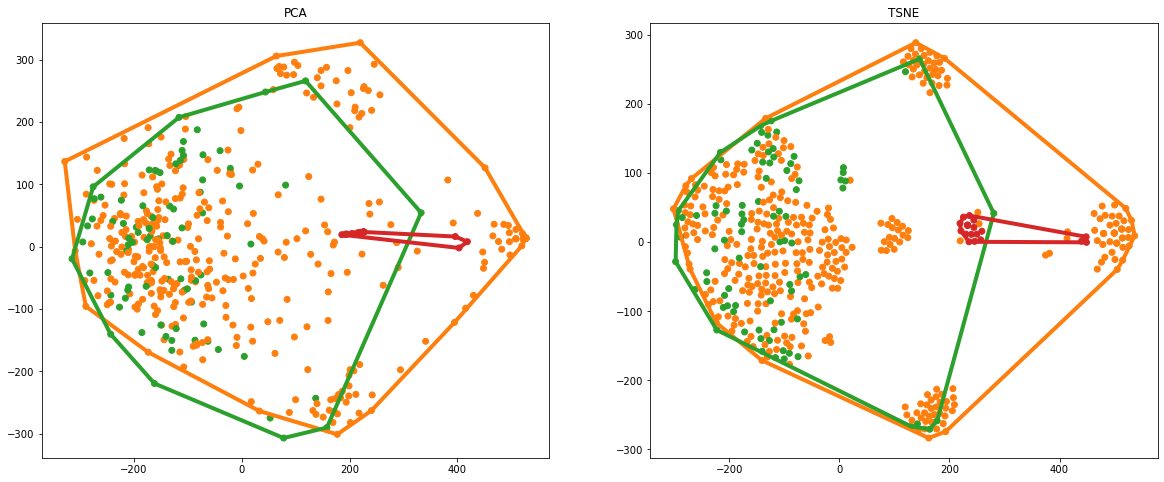

In [319]:
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import seaborn as sns

def plot_cluster_histogram(x,clusters,**kwargs):
    vals = np.hstack([x,clusters.reshape(-1,1)])
    print(vals.shape)
    data = pd.DataFrame(vals,columns=['val','cluster'])
    sns.swarmplot(
        data=data,
        x='cluster',
        hue='cluster',
        palette='colorblind',
    )
    
def plot_cluster_embeddings(x,clusters,
                            perplexity=30,
                            **kwargs
                           ):
    
    colors = plt.get_cmap('tab10')
    plot_colors = [colors(c) for c in clusters]
    
    fsize = 10
    nplots = 2
#     nplots= 3
    fig,ax = plt.subplots(1,nplots,figsize=[fsize*nplots,8])
    
    def encircle(p,ax):
        if len(p) < 3:
            return
        hull = ConvexHull(p,qhull_options='QbB')
        poly = plt.Polygon(p[hull.vertices,:],fc='none',ec=colors(l),linewidth=4)
        ax.add_patch(poly)
    
    x_pca = PCA(2).fit_transform(x)
    ax[0].scatter(x_pca[:,0],x_pca[:,1],c=plot_colors)
    ax[0].set_title('PCA')
    
    sim_matrix = kwargs.get('sim_matrix')
    if sim_matrix is not None:
        tsne = TSNE(2,perplexity=perplexity,metric='precomputed')
        x_tsne = tsne.fit_transform(sim_matrix)
    else:
        if x.shape[0] < 10:
            x_pca_2 = PCA(10).fit_transform(x)
        else:
            x_pca_2 = x[:]
        x_tsne = TSNE(2,init='pca',learning_rate='auto',perplexity=perplexity).fit_transform(x_pca_2)
    ax[1].scatter(x_tsne[:,0],x_tsne[:,1],c=plot_colors)
    ax[1].set_title('TSNE')
    
#     x_isomap = Isomap(n_components = 2).fit_transform(x)
#     ax[2].scatter(x_isomap[:,0],x_isomap[:,1],c=plot_colors)
#     ax[2].set_title('Isomap')
    
    
    for l in np.unique(clusters):
        cluster_pca = x_pca[clusters==l]
        encircle(cluster_pca,ax[0])
        cluster_tsne = x_tsne[clusters==l]
        encircle(cluster_tsne,ax[1])
#         cluster_isomap = x_isomap[clusters==l]
#         encircle(cluster_isomap,ax[2])
    return fig,ax
        
def get_best_results(res_df, select_by='silhouette',minimize=False,**kwargs):
    for k,v in kwargs.items():
        if Utils.iterable(v) and type(v) != type('string'):
            valid = res_df[k].apply(lambda x: ''.join(x)) == ''.join(v)
            res_df =res_df[valid]
        else:
            res_df = res_df[res_df[k] == v]
    best = res_df.sort_values(select_by,ascending=minimize).iloc[0]
    return best

def plot_dvh_results(result_df, r_dset,plot_features=None,**kwargs):
    best = get_best_results(result_df,**kwargs)
    clusters= best.clusters
    print(best)
    if plot_features is None:
        plot_features = best.features
    x = r_dset.get_value_array(plot_features, keep_2d= True)
    if x.shape[0] == 1:
        plot_cluster_histogram(x,clusters)
    else:
        plot_cluster_embeddings(x,clusters)

# temp_features=['mean_dose','V10','V65']
# temp_features=['V15','V25','V35','V45','V55','V65']
# temp_features=['mean_dose']
temp_features=['V5','V10','V15','V20','V25','V30','V35','V40','V45','V50','V55','V60','V65','V70','V75','V80']
plot_dvh_results(result_df,rds,
                 link='ward',
#                  measure='euclidean',
#                  features=temp_features
                )

In [338]:
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.cluster import AffinityPropagation, SpectralClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
def cluster_and_plot(rdset,clusterer,features=None,reducer=None,perplexity=10):
    if features is None:
        features = ['mean_dose']
    x = rdset.get_value_array(features,keep_2d=True)
    if reducer is not None:#pca or something idk
        x = reducer.fit_transform(x)
    clusters = clusterer.fit_predict(x)
    fig,ax = plot_cluster_embeddings(x,clusters,perplexity=perplexity)
    fig.suptitle(str(clusterer) + '|' + str(features) + '|' + str(reducer))
    return

featuresets = [
    ['mean_dose'],
    ['mean_dose','volume'],
    ['V35', 'V40', 'V45'],
    ['V5','V10','V15','V20','V25','V30','V35','V40','V45','V50','V55','V60','V65','V70','V75','V80'],
]
clusterers = [
#     OPTICS(metric='cityblock'),
#     Optics(metric='cosine'),
#     OPTICS(),
    AffinityPropagation(damping=.9),
    GaussianMixture(4),
    GaussianMixture(5),
    GaussianMixture(6),
    BayesianGaussianMixture(n_components=4, covariance_type="full"),
    BayesianGaussianMixture(n_components=5, covariance_type="full"),
    BayesianGaussianMixture(n_components=6, covariance_type="full"),
    SpectralClustering(4),
    SpectralClustering(5),
]
reducers = [
    PCA(3),
    TSNE(3,init='pca',learning_rate='auto'),
    None,
]
for c in clusterers:
    for f in featuresets:
        for r in reducers:
            try:
                cluster_and_plot(rds,c,features=f,reducer=r)
            except Exception as e:
                print(e)

10
-183.4947043770839
8
-186.34200217120443
2
-187.82782156654457
0
-190.81957295658714


,Esophagus_mean_dose,Esophagus_max_dose,Esophagus_volume,Spinal_Cord_mean_dose,Spinal_Cord_max_dose,Spinal_Cord_volume,Lt_Brachial_Plexus_mean_dose,Lt_Brachial_Plexus_max_dose,Lt_Brachial_Plexus_volume,Rt_Brachial_Plexus_mean_dose,Rt_Brachial_Plexus_max_dose,Rt_Brachial_Plexus_volume,Cricopharyngeal_Muscle_mean_dose,Cricopharyngeal_Muscle_max_dose,Cricopharyngeal_Muscle_volume,Cricoid_cartilage_mean_dose,Cricoid_cartilage_max_dose,Cricoid_cartilage_volume,IPC_mean_dose,IPC_max_dose,IPC_volume,MPC_mean_dose,MPC_max_dose,MPC_volume,Brainstem_mean_dose,Brainstem_max_dose,Brainstem_volume,Larynx_mean_dose,Larynx_max_dose,Larynx_volume,Thyroid_cartilage_mean_dose,Thyroid_cartilage_max_dose,Thyroid_cartilage_volume,Rt_Sternocleidomastoid_M_mean_dose,Rt_Sternocleidomastoid_M_max_dose,Rt_Sternocleidomastoid_M_volume,Rt_Mastoid_mean_dose,Rt_Mastoid_max_dose,Rt_Mastoid_volume,Rt_Parotid_Gland_mean_dose,Rt_Parotid_Gland_max_dose,Rt_Parotid_Gland_volume,Rt_Medial_Pterygoid_M_mean_dose,Rt_Medial_Pterygoid_M_max_dose,Rt_Medial_Pterygoid_M_volume,Rt_Lateral_Pterygoid_M_mean_dose,Rt_Lateral_Pterygoid_M_max_dose,Rt_Lateral_Pterygoid_M_volume,Rt_Masseter_M_mean_dose,Rt_Masseter_M_max_dose,Rt_Masseter_M_volume,Lt_Sternocleidomastoid_M_mean_dose,Lt_Sternocleidomastoid_M_max_dose,Lt_Sternocleidomastoid_M_volume,Lt_Mastoid_mean_dose,Lt_Mastoid_max_dose,Lt_Mastoid_volume,Lt_Parotid_Gland_mean_dose,Lt_Parotid_Gland_max_dose,Lt_Parotid_Gland_volume,Lt_Submandibular_Gland_mean_dose,Lt_Submandibular_Gland_max_dose,Lt_Submandibular_Gland_volume,Lt_Medial_Pterygoid_M_mean_dose,Lt_Medial_Pterygoid_M_max_dose,Lt_Medial_Pterygoid_M_volume,Lt_Lateral_Pterygoid_M_mean_dose,Lt_Lateral_Pterygoid_M_max_dose,Lt_Lateral_Pterygoid_M_volume,Lt_Masseter_M_mean_dose,Lt_Masseter_M_max_dose,Lt_Masseter_M_volume,Supraglottic_Larynx_mean_dose,Supraglottic_Larynx_max_dose,Supraglottic_Larynx_volume,SPC_mean_dose,SPC_max_dose,SPC_volume,Rt_Submandibular_Gland_mean_dose,Rt_Submandibular_Gland_max_dose,Rt_Submandibular_Gland_volume,Hyoid_bone_mean_dose,Hyoid_bone_max_dose,Hyoid_bone_volume,Soft_Palate_mean_dose,Soft_Palate_max_dose,Soft_Palate_volume,Genioglossus_M_mean_dose,Genioglossus_M_max_dose,Genioglossus_M_volume,Tongue_mean_dose,Tongue_max_dose,Tongue_volume,Rt_Ant_Digastric_M_mean_dose,Rt_Ant_Digastric_M_max_dose,Rt_Ant_Digastric_M_volume,Lt_Ant_Digastric_M_mean_dose,Lt_Ant_Digastric_M_max_dose,Lt_Ant_Digastric_M_volume,Mylogeniohyoid_M_mean_dose,Mylogeniohyoid_M_max_dose,Mylogeniohyoid_M_volume,Extended_Oral_Cavity_mean_dose,Extended_Oral_Cavity_max_dose,Extended_Oral_Cavity_volume,Mandible_mean_dose,Mandible_max_dose,Mandible_volume,Hard_Palate_mean_dose,Hard_Palate_max_dose,Hard_Palate_volume,Lower_Lip_mean_dose,Lower_Lip_max_dose,Lower_Lip_volume,Upper_Lip_mean_dose,Upper_Lip_max_dose,Upper_Lip_volume,Glottic_Area_mean_dose,Glottic_Area_max_dose,Glottic_Area_volume,BayesianGaussianMixture_n=6,BayesianGaussianMixture_n=5,BayesianGaussianMixture_n=4,BayesianGaussianMixture_n=3
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.0,35.720554,5827.0,14279.479980,23.816881,3008.0,12866.363525,36.247807,6272.0,7139.739990,42.946247,6034.0,5500.030518,49.904351,5747.0,2698.516846,48.690312,6842.0,8964.843750,41.851960,5989.0,2900.390625,66.409821,7380.0,1384.277344,6.866349,2931.0,22704.620361,38.615871,7409.0,24879.913330,45.916222,7262.0,12310.180664,58.239734,6218.0,70371.551514,50.661989,5622.0,745.697021,20.795395,6046.0,29630.126953,46.749825,6654.0,10386.199951,19.794651,5171.0,7918.395996,22.472298,4412.0,27228.240967,66.848603,7399.0,74087.677002,44.221032,6038.0,1557.312012,22.030461,7258.0,27953.338623,70.850570,7280.0,11193.695068,68.632210,7466.0,12322.540283,22.407796,6888.0,9570.465088,32.700148,6657.0,26725.616455,58.817568,7424.0,22119.598389,68.475769,7471.0,15111.694336,50.040773,6631.0,10398.559570,69.126667,7282.0,2101.135254,70.272426,7472.0,11955.871582,65.133044,7297.0,245

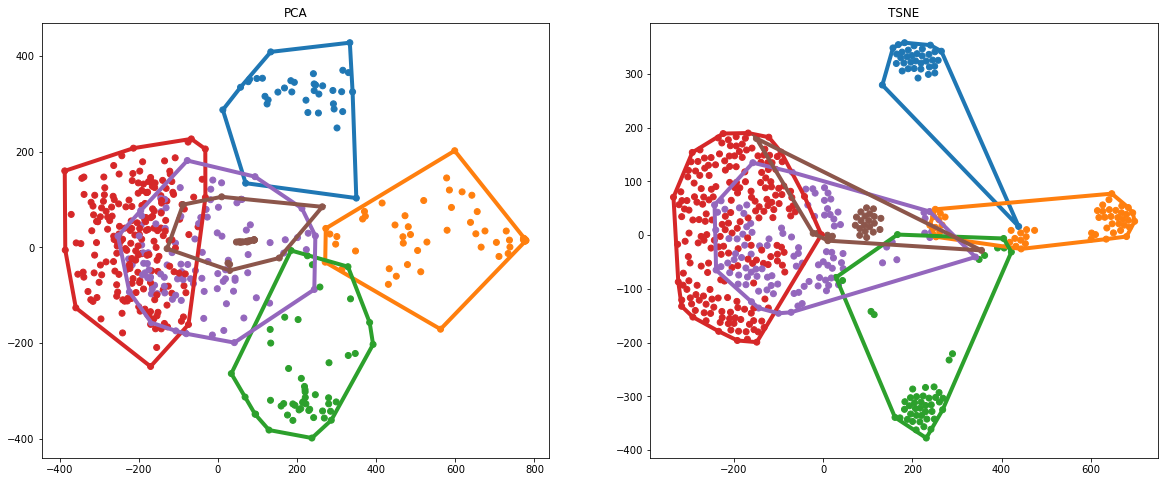

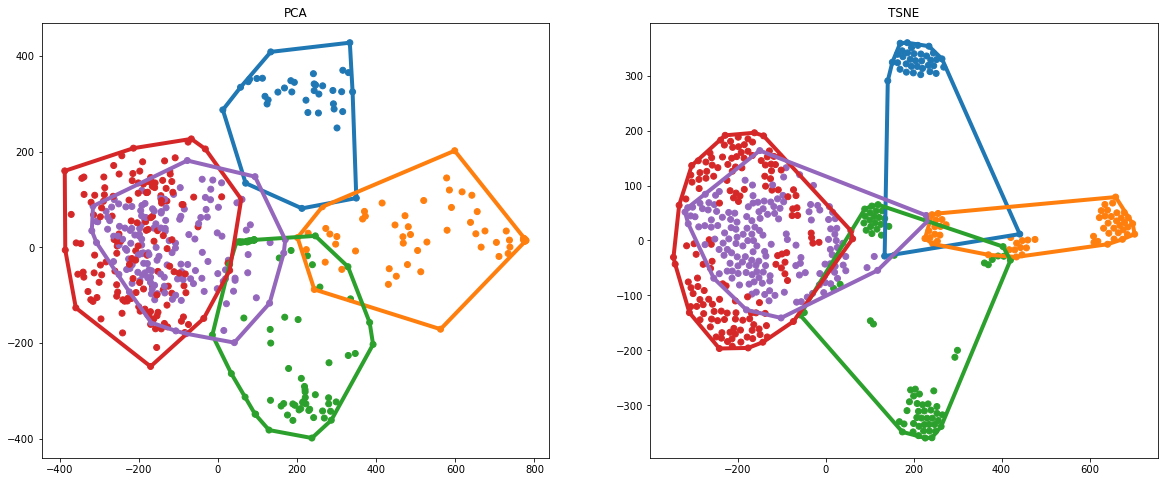

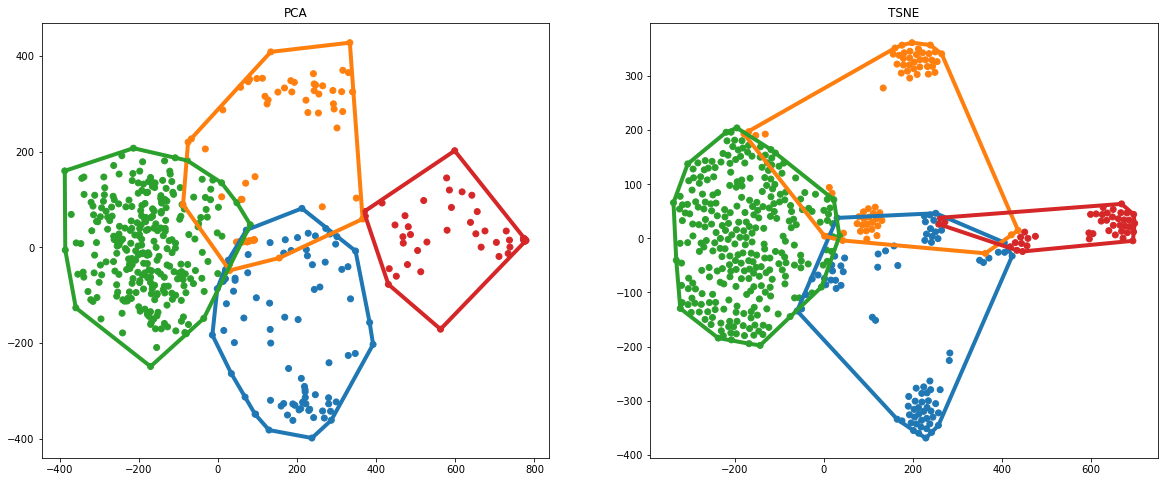

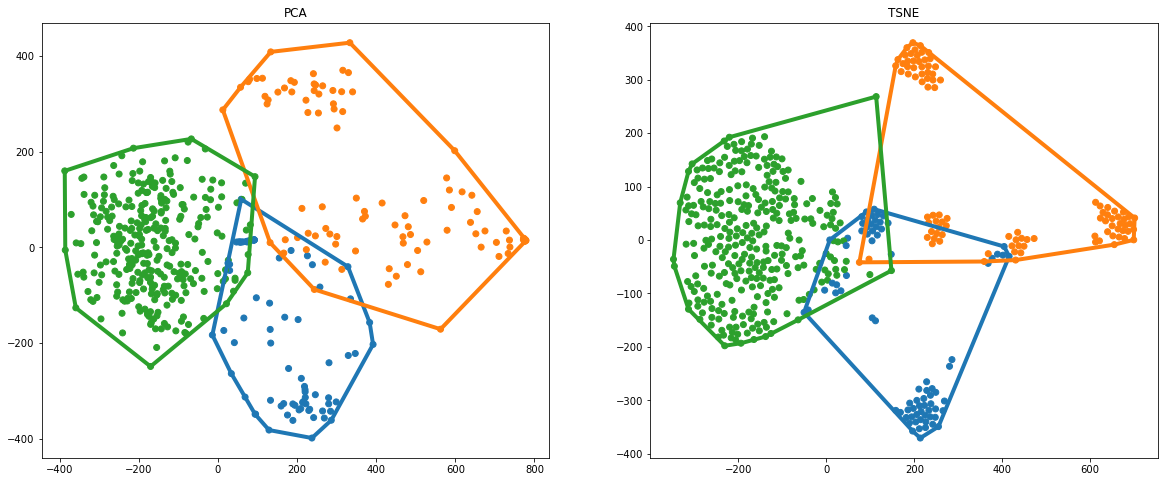

In [479]:
import re 

def make_sklearn_label(x):
    x = str(x)
    new_x  = re.sub("\\([\s\S]*",'',x).replace("Classifier","").replace("Regression","").replace("(","")
    base = re.match(".*estimator=([a-zA-Z]*).*",x)
    if base is not None:
        suffix = base.group(1)
#         print(x,suffix)
        new_x = new_x + '+' + suffix
    
    return new_x

def final_dvh_bmm_results(rdset,clusterers=None,features=None,plot=True,reducer=None):
    if clusterers is None:
        clusterers = [BayesianGaussianMixture(n_init=4,n_components=5, covariance_type="full",random_state=100)]
    if not Utils.iterable(clusterers):
        clusterers = [clusterers]
    if features is None:
        features=['mean_dose','V65','V45','V35','V25','V15']
    if reducer is None:
        reducer= PCA(len(Const.organ_list))
        
    x = rdset.get_value_array(features,keep_2d=True)
    if reducer is not None:
        x_cluster = reducer.fit_transform(x)
#         print(reducer.explained_variance_ratio_.sum())
    else:
        x_cluster = x[:]
        
    return_cols = ['id','mean_dose','max_dose','volume']
    df = rdset.get_value_array(return_cols,as_df=True,keep_2d=True)
    df = pd.DataFrame(df)
    
    for i,clusterer in enumerate(clusterers):
        clusters = clusterer.fit_predict(x_cluster)
        cluster_probs = clusterer.predict_proba(x_cluster)
        print(np.logical_and(cluster_probs>=.01, cluster_probs<=.99).sum())
        print(clusterer.score(x_cluster))
        if plot:
            fig,ax = plot_cluster_embeddings(x,clusters,perplexity=30)
        df[make_sklearn_label(clusterer)+ '_n=' + str(len(np.unique(clusters)))] = clusters
    return df

temp_clusterers = [
    BayesianGaussianMixture(n_init=4,n_components=6, covariance_type="full",random_state=100),
    BayesianGaussianMixture(n_init=4,n_components=5, covariance_type="full",random_state=100),
    BayesianGaussianMixture(n_init=4,n_components=4, covariance_type="full",random_state=100),
    BayesianGaussianMixture(n_init=4,n_components=3, covariance_type="full",random_state=100),
]

dcluster_df = final_dvh_bmm_results(rds,
                                    clusterers = temp_clusterers,
                                    )
dcluster_df.to_csv(Const.data_dir + 'dvh_cluster_12172021.csv')
dcluster_df

In [ ]:
import torch.nn.functional as F

class DvhAutoEncoder(nn.Module):
    
    def __init__(self,
                input_size,
                embedding_dim = 20,
                pre_embedding_dim = 100,
                conv_channels = 2, 
                init_dropout = .2,
                embedding_dropout = .2,
                penult_dropout = .2
                ):
        
        super().__init__()
            
        self.input_size = input_size
        self.n_channels = input_size[-1]
        self.n_organs = input_size[1]
        
        self.init_dropout = init_dropout
        self.embedding_dim =  embedding_dim
        self.pre_embedding_dim = pre_embedding_dim
        self.conv_channels = conv_channels
        
        self.embedding_dropout = embedding_dropout
        self.penult_dropout = penult_dropout
        self.conv_droput = nn.Dropout2d(p=self.init_dropout)
        self.flatten = nn.Flatten().cuda()
        
        self.encoder = self.init_encoder()
        self.decoder = self.init_decoder()
        
    def init_encoder(self):
        conv_in = nn.Conv1d(self.n_channels,self.conv_channels,
                            padding='same')
        #I think this is what the size should be
        conv_dim = self.conv_channels * self.n_organs
        fc_in_1 = nn.Linear(conv_dim, self.pre_embedding_dim)
        embedding_layer = nn.Linear(self.pre_embedding_dim,self.embedding_dim )
        encoder = nn.Sequential(
            self.conv_droput,
            conv_in,
            self.flatten,
            nn.Relu(),
            fc_in_1,
            nn.Relu(),
            embedding_layer,
            nn.Dropout(p=self.embedding_dropout),
            nn.LazyBatchNorm1d(),
        )
        return encoder
    
    def init_decoder(self):
        #idk
        fc_out_1 = nn.LazyLiner(self.pre_embedding_dim)
        conv_dim = self.conv_channels * self.n_organs
        fc_out_2 = nn.Linear(self.pre_embedding_dim)
        conv_out = nn.ConvTranspose1d(self.pre_embedding_dim)
        
    def encode(self,x):
        #I think I need to figure out alignment here
        pass
    
    def decode(self,x):
        pass
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
        
    def forward(self,xin):
        #we keep in nans in the data so I can ignore them in the loss function
        x = torch.nan_to_num(xin)
        #channel should be the 2nd dim for conv networks, I use 3rd usually
        x = x.permute(0,2,1)
        x = self.encode(x)
        x = self.decode(x)
        return x
    
volume_dvh